In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from transformers import BertTokenizer, TFBertModel

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/SM Technologies Task/train.csv')
print(df.head(12))

            id                                            premise  \
0   5130fd2cb5  and these comments were considered in formulat...   
1   5b72532a0b  These are issues that we wrestle with in pract...   
2   3931fbe82a  Des petites choses comme celles-là font une di...   
3   5622f0c60b  you know they can't really defend themselves l...   
4   86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   
5   ed7d6a1e62  Bir çiftlikte birisinin, ağıla kapatılmış bu ö...   
6   5a0f4908a0  ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی...   
7   fdcd1bd867              From Cockpit Country to St. Ann's Bay   
8   7cfb3d272c  Look, it's your skin, but you're going to be i...   
9   8c10229663  Через каждые сто градусов пятна краски меняют ...   
10  a1971593d5  Може да не сме имали всичко, което сме искали ...   
11  2bf4b86d4f                Es fallen zwanzig Prozent Zinsen an   

                                           hypothesis lang_abv   language  \
0   The rules developed i

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.3+ KB
None


In [5]:
print(df['label'].value_counts())

label
0    4176
2    4064
1    3880
Name: count, dtype: int64


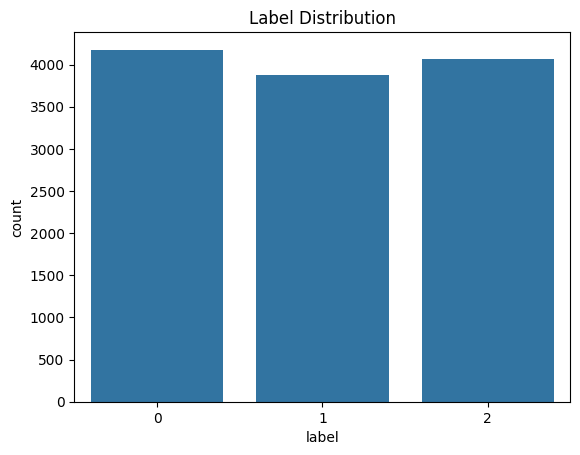

In [6]:
sns.countplot(x=df['label'])
plt.title("Label Distribution")
plt.show()

In [7]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64


In [8]:
print(f"Columns in df: {df.columns}") # Print the column names

Columns in df: Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'], dtype='object')


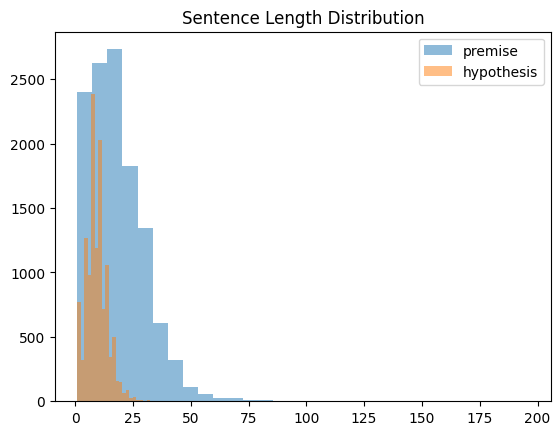

In [9]:
df['premise_length'] = df['premise'].apply(lambda x: len(str(x).split()))
df['hypothesis_length'] = df['hypothesis'].apply(lambda x: len(str(x).split()))
plt.hist(df['premise_length'], bins=30, alpha=0.5, label='premise')
plt.hist(df['hypothesis_length'], bins=30, alpha=0.5, label='hypothesis')
plt.legend()
plt.title("Sentence Length Distribution")
plt.show()

In [10]:
!pip install nltk
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['premise'] = df['premise'].apply(preprocess_text)
df['hypothesis'] = df['hypothesis'].apply(preprocess_text)

In [12]:
print(df.head())

           id                                            premise  \
0  5130fd2cb5        comment considered formulating interim rule   
1  5b72532a0b         issue wrestle practice group law firm said   
2  3931fbe82a  de petite choses comme celleslà font une diffé...   
3  5622f0c60b  know cant really defend like somebody grown uh...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                         hypothesis lang_abv language  label  \
0  rule developed interim put together comment mind       en  English      0   
1               practice group permitted work issue       en  English      2   
2                jessayais daccomplir quelque chose       fr   French      0   
3                                   cant defend age       en  English      0   
4   เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร       th     Thai      1   

   premise_length  hypothesis_length  
0              10                 14  
1              15               

In [13]:
# Feature Extraction using TF-IDF
# Previous 12,120
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['premise'] + " " + df['hypothesis'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print(X_train.shape[0])

9696


In [15]:
print(y_test.shape[0])

2424


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [17]:
#Model Training
#Baseline Model- Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.28052805280528054
              precision    recall  f1-score   support

           0       0.29      0.34      0.31       851
           1       0.23      0.14      0.17       773
           2       0.30      0.36      0.33       800

    accuracy                           0.28      2424
   macro avg       0.27      0.28      0.27      2424
weighted avg       0.27      0.28      0.27      2424



In [18]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

In [19]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.32838283828382836
              precision    recall  f1-score   support

           0       0.34      0.32      0.33       851
           1       0.31      0.28      0.29       773
           2       0.33      0.39      0.36       800

    accuracy                           0.33      2424
   macro avg       0.33      0.33      0.33      2424
weighted avg       0.33      0.33      0.33      2424



In [20]:
#XGBoost Classifier
import xgboost as xgb

In [21]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.3448844884488449
              precision    recall  f1-score   support

           0       0.36      0.50      0.42       851
           1       0.29      0.21      0.24       773
           2       0.37      0.32      0.34       800

    accuracy                           0.34      2424
   macro avg       0.34      0.34      0.33      2424
weighted avg       0.34      0.34      0.33      2424



In [22]:
#Artificial Neural Network (ANN) Model
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [23]:
ann_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

ann_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ann_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 228s 746ms/step - accuracy: 0.3183 - loss: 1.0990 - val_accuracy: 0.3494 - val_loss: 1.0986
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 107s 239ms/step - accuracy: 0.4426 - loss: 1.0711 - val_accuracy: 0.2653 - val_loss: 1.1634
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.7125 - loss: 0.7399 - val_accuracy: 0.2384 - val_loss: 1.4954
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.7973 - loss: 0.4680 - val_accuracy: 0.2302 - val_loss: 1.9115
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.8463 - loss: 0.3538 - val_accuracy: 0.2347 - val_loss: 2.2387
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8808 - loss: 0.2756 - val_accuracy: 0.2405 - val_loss: 2.7009
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9028 - loss: 0.2274 - val_accuracy: 0.2368 - val_loss: 3.0914
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9199 - loss: 0.1842 

In [24]:
#LSTM Model for Sequence-based Learning
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional

In [25]:
max_words = 5000
max_len = 50
embedding_dim = 100

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['premise'] + " " + df['hypothesis'])
X_seq = tokenizer.texts_to_sequences(df['premise'] + " " + df['hypothesis'])
X_seq = tf.keras.preprocessing.sequence.pad_sequences(X_seq, maxlen=max_len)
X_train_seq, X_test_seq, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

lstm_model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.1),
    LSTM(32),
    Dense(3, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train, epochs=5, batch_size=32, validation_data=(X_test_seq, y_test))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3348 - loss: 1.0991 - val_accuracy: 0.3589 - val_loss: 1.0913
Epoch 2/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4924 - loss: 1.0097 - val_accuracy: 0.3515 - val_loss: 1.1434
Epoch 3/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6287 - loss: 0.8169 - val_accuracy: 0.3342 - val_loss: 1.2741
Epoch 4/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7344 - loss: 0.6292 - val_accuracy: 0.3370 - val_loss: 1.5620
Epoch 5/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7977 - loss: 0.4791 - val_accuracy: 0.3300 - val_loss: 1.9654


In [26]:
#Fine-tuning BERT for contextual understanding
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from transformers import AdamWeightDecay
import tensorflow as tf


In [27]:
#Load BERT Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

#Convert DataFrame columns to a list
X_texts = (df['premise'] + " " + df['hypothesis']).tolist()

#Tokenize the text data
X_bert = tokenizer(X_texts, truncation=True, padding=True, max_length=128, return_tensors='tf')

#Train-test split
X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    X_bert['input_ids'].numpy(), y, test_size=0.2, random_state=42
)

#Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_bert, y_train)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_bert, y_test)).batch(16)

#Use the correct optimizer
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

#Compile the model
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#Train the model
model.fit(train_dataset, epochs=3, validation_data=test_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
606/606 [==============================] - 314s 482ms/step - loss: 1.1033 - accuracy: 0.3384 - val_loss: 1.0986 - val_accuracy: 0.3511
Epoch 2/3
606/606 [==============================] - 290s 478ms/step - loss: 1.1010 - accuracy: 0.3398 - val_loss: 1.0985 - val_accuracy: 0.3511
Epoch 3/3
606/606 [==============================] - 289s 478ms/step - loss: 1.1003 - accuracy: 0.3396 - val_loss: 1.0986 - val_accuracy: 0.3205


In [28]:
#Model Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
y_pred_rf_proba = rf.predict_proba(X_test)
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_rf_proba, multi_class='ovr'))

Confusion Matrix:
[[287 195 369]
 [361 106 306]
 [353 160 287]]
AUC-ROC Score: 0.43135984004557715


In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_random = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=5, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
print("Best Parameters:", rf_random.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=None, min_samples_split=10, n_estimators=150; total time=  57.9s
[CV] END max_depth=None, min_samples_split=10, n_estimators=150; total time=  58.6s
[CV] END max_depth=None, min_samples_split=10, n_estimators=150; total time=  58.3s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END .max_depth=20, min_samples_spli

In [31]:
# Final Evaluation with Optimized RF Model
y_pred_optimized = rf_random.predict(X_test)
print("Optimized RF Accuracy:", accuracy_score(y_test, y_pred_optimized))
print(classification_report(y_test, y_pred_optimized))

Optimized RF Accuracy: 0.3634488448844885
              precision    recall  f1-score   support

           0       0.36      0.80      0.50       851
           1       0.32      0.03      0.06       773
           2       0.38      0.23      0.28       800

    accuracy                           0.36      2424
   macro avg       0.36      0.35      0.28      2424
weighted avg       0.36      0.36      0.29      2424



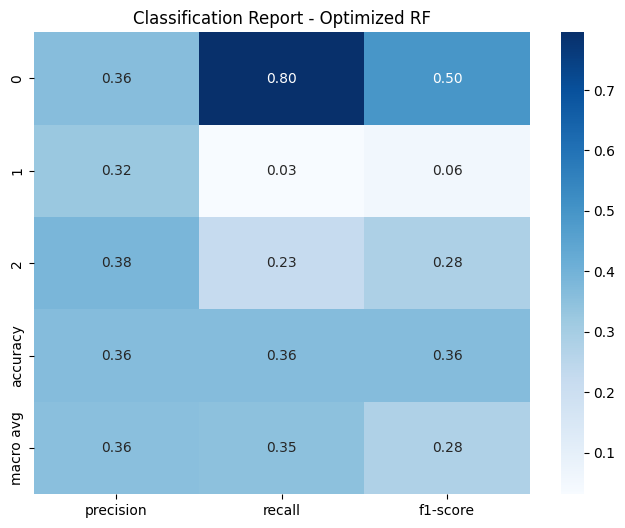

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred_optimized, output_dict=True)

# Convert report into a DataFrame for visualization
df_report = pd.DataFrame(report).transpose()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")

# Title and display
plt.title("Classification Report - Optimized RF")
plt.show()

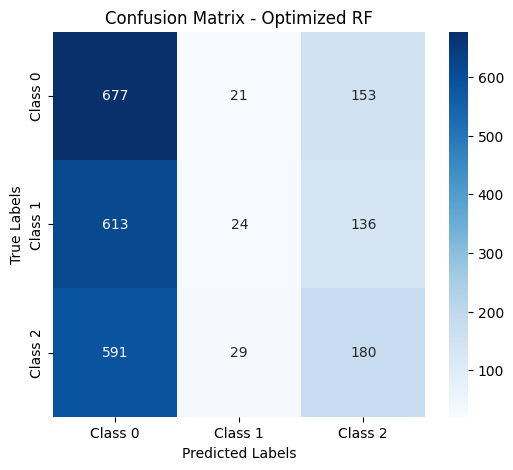

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_optimized)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Optimized RF")
plt.show()